In [23]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


In [25]:
import scanpy as sc
import scvelo as scv

# data = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')
data = sc.read('/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')
data.shape

(161764, 20568)

In [26]:
data.shape

(161764, 20568)

In [27]:
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [28]:
label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [29]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level_1_alpha0.01/Level1_result


In [30]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level_1_alpha0.01/Level1_result')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'./{celltype}/{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    print(celltype, 'Feature count:', feature_df.shape[0])
    print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    print('------------------')

B Feature count: 17
B Positive feature count: 9
------------------
CD4 T Feature count: 1786
CD4 T Positive feature count: 36
------------------
CD8 T Feature count: 26
CD8 T Positive feature count: 9
------------------
DC Feature count: 1
DC Positive feature count: 0
------------------
Mono Feature count: 22
Mono Positive feature count: 14
------------------
NK Feature count: 27
NK Positive feature count: 15
------------------
other Feature count: 1
other Positive feature count: 0
------------------
other T Feature count: 2
other T Positive feature count: 0
------------------


In [31]:
features_dict.keys()

dict_keys(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'])

## LR model for each celltype (e.g. B cells)

In [39]:
celltype = 'B'

# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X  # 17 features for B cells
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(129411, 17)
(32353, 17)
129411
32353


In [28]:
clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)

LogisticRegression()

In [29]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
precision = precision_score(y_test, y_pred)  # average='macro'
print("Precision: {:.2f}%".format(precision * 100))
f1 = f1_score(y_test, y_pred)
print("F1: {:.2f}%".format(f1 * 100))

Accuracy: 99.91%
Precision: 99.46%
F1: 99.49%


In [30]:
clf.coef_

array([[-0.16309671,  0.34545244, -0.26263518,  0.34050093,  0.3282183 ,
         0.33953807, -0.09215408,  0.28160108,  0.52394131,  0.04041433,
         3.26845003, -0.29433993,  0.11375673,  0.43580387, -0.17845087,
         0.6867258 ,  0.3060501 ]])

### B cells: learning curve

In [ ]:
celltype = 'B'

# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X  # 17 features for B cells
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

In [46]:
from sklearn.model_selection import learning_curve

train_sizes = [int(161764*i) for i in [0.1, 0.2, 0.4, 0.6, 0.8]]
print(train_sizes)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0),
    X = X, y = y, 
    train_sizes = train_sizes, cv = 5,
    scoring = 'neg_mean_squared_error', 
    shuffle=True)


[16176, 32352, 64705, 97058, 129411]


In [47]:
print('Train sizes: ', train_sizes)
print('Training scores:\n\n', train_scores)
print('Validation scores:\n\n', validation_scores)

Train sizes:  [ 16176  32352  64705  97058 129411]
Training scores:

 [[-0.00098912 -0.00080366 -0.00043274 -0.00098912 -0.00098912]
 [-0.00108185 -0.00068002 -0.00049456 -0.00111276 -0.00086548]
 [-0.00092729 -0.00077274 -0.00077274 -0.00088092 -0.00095819]
 [-0.00075213 -0.0006594  -0.00084486 -0.00083455 -0.00085516]
 [-0.00078819 -0.00070319 -0.00083455 -0.00089637 -0.00089637]]
Validation scores:

 [[-0.00148363 -0.00173091 -0.00098909 -0.00095818 -0.00074184]
 [-0.00114363 -0.00139091 -0.00086545 -0.00058727 -0.00071093]
 [-0.00120545 -0.00132909 -0.00080363 -0.00058727 -0.0006182 ]
 [-0.00136    -0.00123636 -0.00074182 -0.00071091 -0.00068002]
 [-0.00117454 -0.00123636 -0.00074182 -0.00068    -0.00058729]]


In [48]:
# mean value of each row
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print(train_scores_mean)
print()
print(validation_scores_mean)

[0.00084075 0.00084693 0.00086238 0.00078922 0.00082373]

[0.00118073 0.00093964 0.00090873 0.00094582 0.000884  ]


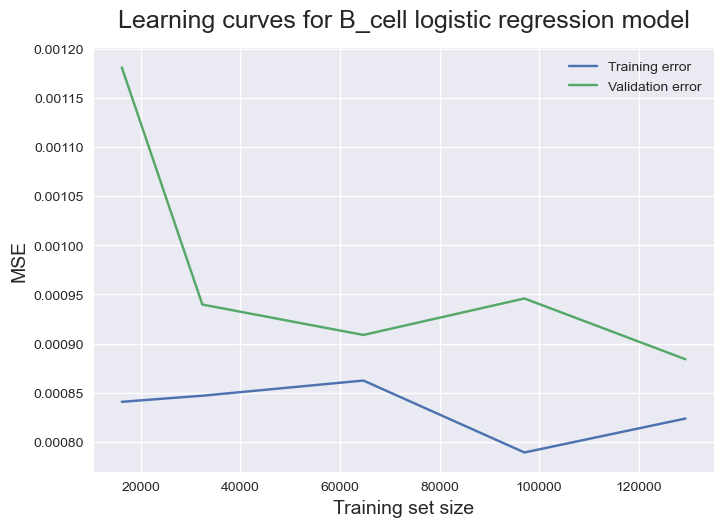

In [51]:
# Plot the learning curve
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for B_cell logistic regression model', fontsize = 18, y = 1.03)
plt.legend()

### B cells: k-fold CV

In [10]:
celltype = 'B'

# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X  # 17 features for B cells
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
# clf.fit(X_train, y_train)

# KFold cross validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)

cross_val_results = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')

In [13]:
# Print the accuracy for each fold
for i, acc in enumerate(cross_val_results):
    print(f"Fold {i+1}: Accuracy = {acc}")

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(cross_val_results)
print(f"Mean Accuracy: {mean_accuracy:.4f}")

Fold 1: Accuracy = 0.999010910889253
Fold 2: Accuracy = 0.9992272741322289
Fold 3: Accuracy = 0.9990418199239638
Fold 4: Accuracy = 0.9992272741322289
Fold 5: Accuracy = 0.9991963402571711
Mean Accuracy: 0.9991


In [17]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)

# Perform k-fold cross-validation with multiple metrics
cross_val_results = cross_validate(clf, X, y, cv=kf, scoring=['accuracy', 'precision', 'f1'])


In [20]:
cross_val_results

{'fit_time': array([0.42172527, 0.55084229, 0.39794087, 0.41575027, 0.43595386]),
 'score_time': array([0.02806664, 0.02883363, 0.02737617, 0.02677178, 0.02868319]),
 'test_accuracy': array([0.99901091, 0.99922727, 0.99904182, 0.99922727, 0.99919634]),
 'test_precision': array([0.99422174, 0.99562682, 0.99530516, 0.99607423, 0.99814195]),
 'test_f1': array([0.99422174, 0.99544544, 0.99440736, 0.99554129, 0.9951834 ])}

In [22]:
# Calculate and print the mean results across all folds
mean_accuracy = np.mean(cross_val_results['test_accuracy'])
mean_precision = np.mean(cross_val_results['test_precision'])
mean_f1_score = np.mean(cross_val_results['test_f1'])
print(f"Mean Accuracy: {mean_accuracy:.4f}, Mean Precision: {mean_precision:.4f}, Mean F1-score: {mean_f1_score:.4f}")

Mean Accuracy: 0.9991, Mean Precision: 0.9959, Mean F1-score: 0.9950


## Function: LR model for each cell type

In [33]:
def LR_classifier(data, all_features, celltype):
    print('Constructing classifier for:', celltype)
    # subset data to celltype features
    celltype_features = all_features[celltype]['Gene'].tolist()
    X = data[:, celltype_features].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)  # average='macro'
    print("Precision: {:.2f}%".format(precision * 100))
    f1 = f1_score(y_test, y_pred)
    print("F1: {:.2f}%".format(f1 * 100))

    # model metrics
    metrics = [accuracy, precision, f1]

    return clf, metrics

In [33]:
import pickle
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Classifier')

In [34]:
import pickle

all_metrics = {}
for celltype in types:
    clf, metrics = LR_classifier(data, features_dict, celltype)
    all_metrics[celltype] = metrics

    filename = f'LR_{celltype}_l1_a.01.pkl'.replace(' ', '_')
    # with open(filename, 'wb') as f:
    #     pickle.dump(clf, f)
    print('------------------')

Constructing classifier for: B
Accuracy: 99.91%
Precision: 99.46%
F1: 99.49%
------------------
Constructing classifier for: CD4 T
Accuracy: 96.23%
Precision: 92.53%
F1: 92.56%
------------------
Constructing classifier for: CD8 T
Accuracy: 97.10%
Precision: 92.51%
F1: 90.60%
------------------
Constructing classifier for: DC
Accuracy: 97.78%
Precision: 0.00%
F1: 0.00%
------------------
Constructing classifier for: Mono
Accuracy: 99.02%
Precision: 97.43%
F1: 98.40%
------------------
Constructing classifier for: NK
Accuracy: 99.18%
Precision: 96.44%
F1: 96.45%
------------------
Constructing classifier for: other
Accuracy: 97.88%
Precision: 100.00%
F1: 0.58%
------------------
Constructing classifier for: other T
Accuracy: 95.79%
Precision: 0.00%
F1: 0.00%
------------------


In [35]:
# [accuracy, precision, f1]
all_metrics

{'B': [0.9991345470280963, 0.9945691527878349, 0.9949293734154292],
 'CD4 T': [0.9622909776527679, 0.9252985620277846, 0.9256369620870413],
 'CD8 T': [0.9710073254412265, 0.9251227495908347, 0.906030855539972],
 'DC': [0.9778073130776126, 0.0, 0.0],
 'Mono': [0.9902018359966618, 0.9742974297429743, 0.9839907075400232],
 'NK': [0.9918091058016258, 0.9643813604713444, 0.9645105129235302],
 'other': [0.9787964021883596, 1.0, 0.005797101449275362],
 'other T': [0.9579018947238278, 0.0, 0.0]}

In [38]:
metrics_df = pd.DataFrame(all_metrics, index=['Accuracy', 'Precision', 'F1'])
metrics_df

,B,CD4 T,CD8 T,DC,Mono,NK,other,other T
Accuracy,0.999135,0.962291,0.971007,0.977807,0.990202,0.991809,0.978796,0.957902
Precision,0.994569,0.925299,0.925123,0.000000,0.974297,0.964381,1.000000,0.000000
F1,0.994929,0.925637,0.906031,0.000000,0.983991,0.964511,0.005797,0.000000


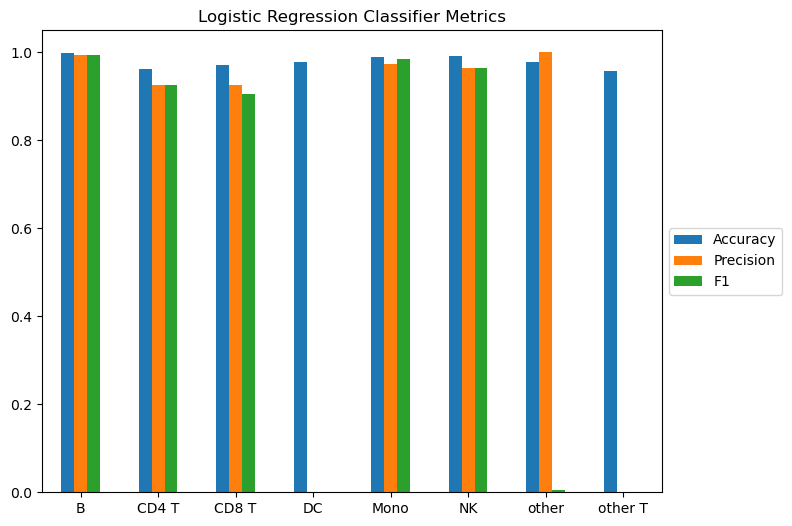

In [43]:
# Plot metrics for each celltype
ax = metrics_df.T.plot.bar(rot=0, figsize=(8,6), title='Logistic Regression Classifier Metrics')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))